In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
from scipy.stats import spearmanr, pearsonr
import numpy as np
import gseapy as gp
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import mygene


In [2]:
lung_epithelial_cell_types = ["club cell","respiratory tract hillock cell","respiratory basal cell","pulmonary alveolar type 2 cell","pulmonary alveolar type 1 cell","multiciliated epithelial cell","pulmonary neuroendocrine cell","bronchial goblet cell","acinar cell","brush cell of tracheobronchial tree"]

In [3]:
lung_cz_healthy_epithelial = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/normal_lung/lung_cz_healthy_epithelial.h5ad")

In [30]:
'''
mg = mygene.MyGeneInfo()
query_results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
id_to_symbol = {entry['query']: entry.get('symbol', entry['query']) for entry in query_results}

ensembl_ids = lung_cz_healthy_epithelial.var_names.tolist()
gene_symbols = [id_to_symbol.get(gene, gene) for gene in ensembl_ids]

var_df = lung_cz_healthy_epithelial.var.copy()
var_df['original_ensembl'] = ensembl_ids
var_df['gene_symbol'] = gene_symbols

var_df = var_df[~var_df.duplicated('gene_symbol', keep='first')]

lung_cz_healthy_epithelial = lung_cz_healthy_epithelial[:, var_df['original_ensembl']].copy()

lung_cz_healthy_epithelial.var_names = var_df['gene_symbol'].values
'''

25 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000226506', 2), ('ENSG00000228044', 2), ('ENSG00000228566', 2), ('E
904 input query terms found no hit:	['ENSG00000230427', 'ENSG00000215067', 'ENSG00000272146', 'ENSG00000234166', 'ENSG00000255568', 'ENS


In [32]:
#lung_cz_healthy_epithelial.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/normal_lung/lung_cz_healthy_epithelial.h5ad")

In [4]:
tang_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tang_adata_qc_filtered.h5ad")
chan_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_qc_filtered.h5ad")


/tmp/ipykernel_681534/3807193642.py:3: DtypeWarning: Columns (22,23,24,27,34,36,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  lung_cells = pd.read_csv("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/lung_cells_gene_expr.csv")


In [4]:
lung_cells = pd.read_csv("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/lung_cells_gene_expr.csv")

/tmp/ipykernel_3075874/2633038527.py:1: DtypeWarning: Columns (22,23,24,27,34,36,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  lung_cells = pd.read_csv("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/lung_cells_gene_expr.csv")


In [5]:
# Tang preprocessing

tumor_adata = tang_adata[tang_adata.obs['tissue_type'] == 'PT', :]
tumor_adata = tumor_adata[tumor_adata.obs['cell_type'] == 'tumor', :]
tumor_adata_filtered = tumor_adata[~tumor_adata.obs['patient'].isin(['P1', 'P14']), :]

scales_counts = sc.pp.normalize_total(tumor_adata_filtered, target_sum=1e6, inplace=False, exclude_highly_expressed=True)
tumor_adata_filtered.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

tumor_adata_normalized = sc.AnnData(
    X = tumor_adata_filtered.layers["log1p_norm"],
    obs = tumor_adata_filtered.obs.copy(),
    var = tumor_adata_filtered.var.copy(),
    uns = tumor_adata_filtered.uns.copy(),
    layers = tumor_adata_filtered.layers.copy()
)

sc.pp.highly_variable_genes(tumor_adata_normalized, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(tumor_adata_normalized, svd_solver="arpack")
sc.tl.tsne(tumor_adata_normalized, use_rep="X_pca")
sc.pp.neighbors(tumor_adata_normalized)
sc.tl.umap(tumor_adata_normalized)

/hpc/packages/minerva-rocky9/py_packages/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-05-10 12:16:58.443932: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 12:16:58.725305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-10 12:16:58.864877: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-10 12:16:58.867652: E external/local_xla/xla/stream_executor/cuda/cuda_bla

<Axes: title={'center': 'Tian et al. (n=1757)'}, xlabel='UMAP1', ylabel='UMAP2'>

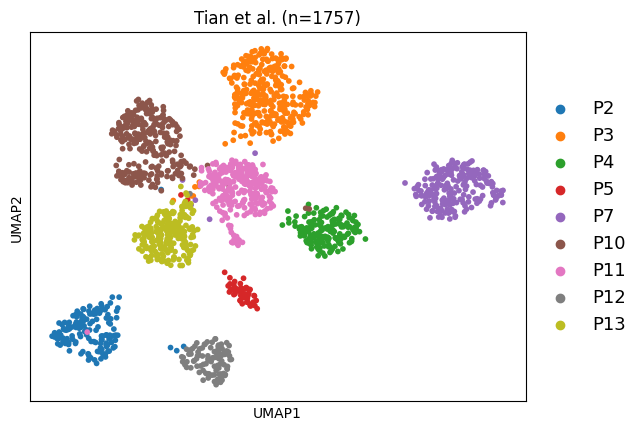

In [6]:
# UMAP did not segregate according to any QC metric
tang_num_cells = tumor_adata_normalized.n_obs
sc.pl.umap(tumor_adata_normalized, color="patient",title=f"Tian et al. (n={tang_num_cells})", add_outline=False,show=False,legend_fontsize=13)
#plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/plots/tian_umap_patients.png", dpi=600,bbox_inches='tight')

<Axes: title={'center': 'Chan et al. (n=49685)'}, xlabel='UMAP1', ylabel='UMAP2'>

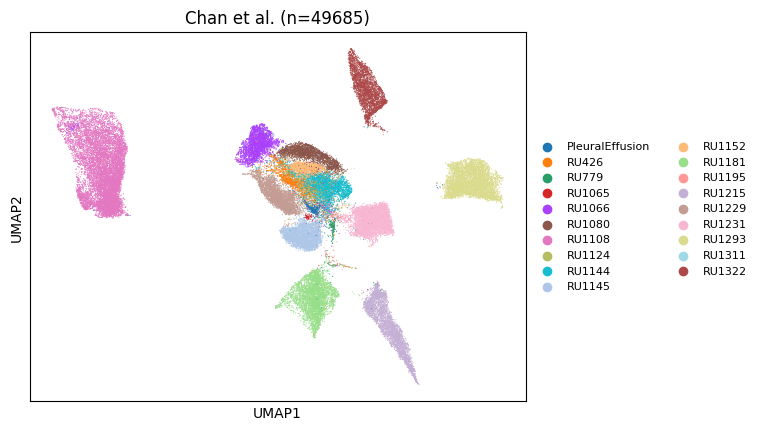

In [7]:
chan_num_cells = chan_adata.n_obs
sc.pl.umap(chan_adata, color='patient',title=f"Chan et al. (n={chan_num_cells})", add_outline=False,show=False,legend_fontsize=8)
#plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/plots/chan_umap_patients.png", dpi=600,bbox_inches='tight')

In [5]:
NE_genes = ['KIF1A', 'GNAO1','DPYSL5','SYP','CHGA','KIF5C','SCAMP5','TUBB2B','SCG3','GNG4','CRMP1','RUNDC3A','CHRNB2','BEX1','PGBD5','CHGB','RAB39A', 'NCAM1','TMEM198','AP3B2','UNC13A','MAPK8IP1','SNAP25','SOGA3','INSM1']
non_NE_genes = ['HFE','ITGB4','IL18','ANXA3','CAV2','GPRC5A','AHNAK','ADGRG6','IFITM3','CAV1','EPHA2','GPX8','LGALS3','CYR61','RHBDF1','NT5E','WWTR1','NABP1','OSMR','YAP1','TGFBR2','ANXA1','S100A16','MYOF','EMP1']

In [6]:
combined_avg_expression = pd.read_csv("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/ne_non_ne_gene_expr.csv", index_col=0)
combined_avg_expression = combined_avg_expression.rename(index={'CCN1': 'CYR61'})
lung_cells.rename(columns={"CCN1": "CYR61"}, inplace=True)
lung_cells.set_index("StrippedCellLineName", inplace=True)

In [7]:
lung_cells_subset = lung_cells[NE_genes+non_NE_genes]

In [7]:
tumor_adata_normalized = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tumor_adata_normalized_nescore.h5ad")
chan_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_nescore.h5ad")
lung_cz_healthy_epithelial = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/normal_lung/lung_cz_healthy_epithelial_nescore.h5ad")

In [8]:
tang_adata_ne_score_genes = tumor_adata_normalized.layers['log1p_norm'][:, [tumor_adata_normalized.var_names.get_loc(gene) for gene in NE_genes+non_NE_genes]]

In [50]:
chan_adata

AnnData object with n_obs × n_vars = 49685 × 22216
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'patient', 'tissue', 'treatment', 'procedure', 'SCLC_subtype', 'SCLC_subtype_plus_TP53_RB1_wt', 'pval_SCLC-A', 'pval_SCLC-N', 'pval_SCLC-P', 'NEUROD genes', 'MHCI_PRESENTATION', 'MHCII_PRESENTATION', 'SCLC_major_subtype_of_sample', 'clusters', 'treatment_categorized', 'recurrent_cluster', 'histo', 'clusters_fine', 'n_genes', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'pearson_correlation_to_ne', 'pearson_correlation_to_nonne', 'NE_score', 'NE_status'
    var: 'knnDREMI|PLCG2', 'PLCG2_modules', 'AXONOGENESIS', 'NEURON_DIFFERENTIATION', 'NEUROPEPTIDE_RECEPTOR', 'EMT', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cells_removed', 'diffmap_evals', 'neighbors', '

In [51]:
chan_adata_ne_score_genes = chan_adata.layers['log2(X+0.1)'][:, [chan_adata.var_names.get_loc(gene) for gene in NE_genes+non_NE_genes]]

In [48]:
'CCN1' in lung_cz_healthy_epithelial.var_names


True

In [11]:
lung_cz_healthy_epithelial.var_names = lung_cz_healthy_epithelial.var_names.str.replace('MTCL3', 'SOGA3')
lung_cz_healthy_epithelial.var_names = lung_cz_healthy_epithelial.var_names.str.replace('CCN1', 'CYR61')


In [10]:
cz_adata_ne_score_genes = lung_cz_healthy_epithelial[:, [lung_cz_healthy_epithelial.var_names.get_loc(gene) for gene in NE_genes+non_NE_genes]]

In [11]:
cz_adata_ne_score_genes = cz_adata_ne_score_genes.X.toarray()

In [8]:
avg_ne_expression = combined_avg_expression.loc[NE_genes+non_NE_genes, 'NE_cells'].values
avg_nonne_expression = combined_avg_expression.loc[NE_genes+non_NE_genes, 'non_NE_cells'].values

In [14]:
tang_pearson_correlation_to_ne = []
tang_pearson_correlation_to_nonne = []

for cell_idx in range(tang_adata_ne_score_genes.shape[0]):
    cell_expression = tang_adata_ne_score_genes[cell_idx, :].flatten()
    nonzero_mask = cell_expression != 0
    
    filtered_cell_expr = cell_expression[nonzero_mask]
    filtered_avg_ne_expr = avg_ne_expression[nonzero_mask]
    filtered_avg_nonne_expr = avg_nonne_expression[nonzero_mask]
    
    if len(filtered_cell_expr) < 5:
        tang_pearson_correlation_to_ne.append(np.nan)
        tang_pearson_correlation_to_nonne.append(np.nan)
    else:
        # Check if filtered reference vector is still constant
        if np.std(filtered_cell_expr) == 0 or np.std(filtered_avg_ne_expr) == 0 or np.std(filtered_avg_nonne_expr) == 0:
            tang_pearson_correlation_to_ne.append(np.nan)
            tang_pearson_correlation_to_nonne.append(np.nan)
        else:
            ne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_ne_expr)
            nonne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_nonne_expr)
            tang_pearson_correlation_to_ne.append(ne_correlation)
            tang_pearson_correlation_to_nonne.append(nonne_correlation)

In [53]:
chan_pearson_correlation_to_ne = []
chan_pearson_correlation_to_nonne = []

for cell_idx in range(chan_adata_ne_score_genes.shape[0]):
    cell_expression = chan_adata_ne_score_genes[cell_idx, :].flatten()
    nonzero_mask = cell_expression != 0
    
    filtered_cell_expr = cell_expression[nonzero_mask]
    filtered_avg_ne_expr = avg_ne_expression[nonzero_mask]
    filtered_avg_nonne_expr = avg_nonne_expression[nonzero_mask]
    
    if len(filtered_cell_expr) < 5:
        chan_pearson_correlation_to_ne.append(np.nan)
        chan_pearson_correlation_to_nonne.append(np.nan)
    else:
        # Check if filtered reference vector is still constant
        if np.std(filtered_cell_expr) == 0 or np.std(filtered_avg_ne_expr) == 0 or np.std(filtered_avg_nonne_expr) == 0:
            chan_pearson_correlation_to_ne.append(np.nan)
            chan_pearson_correlation_to_nonne.append(np.nan)
        else:
            ne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_ne_expr)
            nonne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_nonne_expr)
            chan_pearson_correlation_to_ne.append(ne_correlation)
            chan_pearson_correlation_to_nonne.append(nonne_correlation)

In [9]:
ref_pearson_correlation_to_ne = []
ref_pearson_correlation_to_nonne = []

for cell_idx in lung_cells_subset.index:
    lung_cells_subset_expr = lung_cells_subset.loc[cell_idx, :].values  # Get expression values as a numpy array

    ne_correlation, _ = pearsonr(lung_cells_subset_expr, avg_ne_expression)
    nonne_correlation, _ = pearsonr(lung_cells_subset_expr, avg_nonne_expression)

    ref_pearson_correlation_to_ne.append(ne_correlation)
    ref_pearson_correlation_to_nonne.append(nonne_correlation)

In [33]:
cz_pearson_correlation_to_ne = []
cz_pearson_correlation_to_nonne = []

for cell_idx in range(cz_adata_ne_score_genes.shape[0]):
    cell_expression = cz_adata_ne_score_genes[cell_idx, :].flatten()
    nonzero_mask = cell_expression != 0
    
    filtered_cell_expr = cell_expression[nonzero_mask]
    filtered_avg_ne_expr = avg_ne_expression[nonzero_mask]
    filtered_avg_nonne_expr = avg_nonne_expression[nonzero_mask]
    
    if len(filtered_cell_expr) < 5:
        cz_pearson_correlation_to_ne.append(np.nan)
        cz_pearson_correlation_to_nonne.append(np.nan)
    else:
        # Check if filtered reference vector is still constant
        if np.std(filtered_cell_expr) == 0 or np.std(filtered_avg_ne_expr) == 0 or np.std(filtered_avg_nonne_expr) == 0:
            cz_pearson_correlation_to_ne.append(np.nan)
            cz_pearson_correlation_to_nonne.append(np.nan)
        else:
            ne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_ne_expr)
            nonne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_nonne_expr)
            cz_pearson_correlation_to_ne.append(ne_correlation)
            cz_pearson_correlation_to_nonne.append(nonne_correlation)

/tmp/ipykernel_681534/1712052020.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_ne_expr)
/tmp/ipykernel_681534/1712052020.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  nonne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_nonne_expr)


In [11]:
lung_cells_subset["NE_score"] = (np.array(ref_pearson_correlation_to_ne) - np.array(ref_pearson_correlation_to_nonne))/2
'''
tumor_adata_normalized.obs['pearson_correlation_to_ne']=tang_pearson_correlation_to_ne
tumor_adata_normalized.obs['pearson_correlation_to_nonne']=tang_pearson_correlation_to_nonne
tumor_adata_normalized.obs['NE_score'] = (
    tumor_adata_normalized.obs['pearson_correlation_to_ne'] - tumor_adata_normalized.obs['pearson_correlation_to_nonne']
) / 2

lung_cz_healthy_epithelial.obs['pearson_correlation_to_ne']=cz_pearson_correlation_to_ne
lung_cz_healthy_epithelial.obs['pearson_correlation_to_nonne']=cz_pearson_correlation_to_nonne
lung_cz_healthy_epithelial.obs['NE_score'] = (
    lung_cz_healthy_epithelial.obs['pearson_correlation_to_ne'] - lung_cz_healthy_epithelial.obs['pearson_correlation_to_nonne']
) / 2'''

/tmp/ipykernel_3075874/563559059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung_cells_subset["NE_score"] = (np.array(ref_pearson_correlation_to_ne) - np.array(ref_pearson_correlation_to_nonne))/2


"\ntumor_adata_normalized.obs['pearson_correlation_to_ne']=tang_pearson_correlation_to_ne\ntumor_adata_normalized.obs['pearson_correlation_to_nonne']=tang_pearson_correlation_to_nonne\ntumor_adata_normalized.obs['NE_score'] = (\n    tumor_adata_normalized.obs['pearson_correlation_to_ne'] - tumor_adata_normalized.obs['pearson_correlation_to_nonne']\n) / 2\n\nlung_cz_healthy_epithelial.obs['pearson_correlation_to_ne']=cz_pearson_correlation_to_ne\nlung_cz_healthy_epithelial.obs['pearson_correlation_to_nonne']=cz_pearson_correlation_to_nonne\nlung_cz_healthy_epithelial.obs['NE_score'] = (\n    lung_cz_healthy_epithelial.obs['pearson_correlation_to_ne'] - lung_cz_healthy_epithelial.obs['pearson_correlation_to_nonne']\n) / 2"

In [54]:
chan_adata.obs['pearson_correlation_to_ne']=chan_pearson_correlation_to_ne
chan_adata.obs['pearson_correlation_to_nonne']=chan_pearson_correlation_to_nonne
chan_adata.obs['NE_score'] = (
    chan_adata.obs['pearson_correlation_to_ne'] - chan_adata.obs['pearson_correlation_to_nonne']
) / 2

In [59]:
tumor_adata_normalized.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tumor_adata_normalized_nescore.h5ad")
chan_adata.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_nescore.h5ad")
lung_cz_healthy_epithelial.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/normal_lung/lung_cz_healthy_epithelial_nescore.h5ad")

/tmp/ipykernel_698093/840179538.py:15: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  obs_df['cell_type'] = obs_df['cell_type'].replace(short_labels)


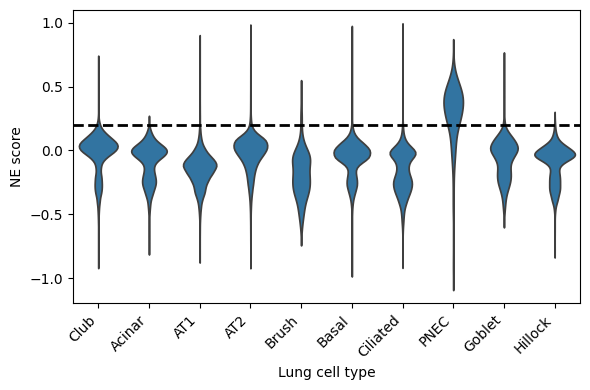

In [14]:
short_labels = {
    "club cell": "Club",
    "acinar cell": "Acinar",
    "pulmonary alveolar type 1 cell":"AT1",
    "pulmonary alveolar type 2 cell":"AT2",
    "brush cell of tracheobronchial tree":"Brush",
    "respiratory basal cell": "Basal",
    "multiciliated epithelial cell": "Ciliated",
    "pulmonary neuroendocrine cell": "PNEC",
    "bronchial goblet cell": "Goblet",
    "respiratory tract hillock cell": "Hillock"
}

obs_df = lung_cz_healthy_epithelial.obs[['NE_score', 'cell_type']].dropna().copy()
obs_df['cell_type'] = obs_df['cell_type'].replace(short_labels)

# Plot
plt.figure(figsize=(6, 4))
sns.violinplot(x="cell_type", y="NE_score", data=obs_df, inner=None)
plt.axhline(y=0.2, color='black', linestyle='--', linewidth=2)


#plt.title("NE Score by Cell Type")
plt.ylabel("NE score")
plt.xlabel("Lung cell type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/normal_cells_nescore_violin.png", dpi=600)


/tmp/ipykernel_698093/2905363966.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  obs_df['cell_type'] = obs_df['cell_type'].replace(short_labels)
/tmp/ipykernel_698093/2905363966.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = obs_df.groupby(['cell_type', 'NE_status']).size().unstack(fill_value=0)


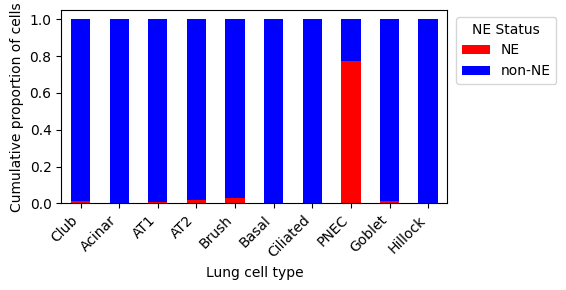

In [29]:
obs_df = lung_cz_healthy_epithelial.obs[['NE_score', 'cell_type']].dropna().copy()
obs_df['cell_type'] = obs_df['cell_type'].replace(short_labels)
obs_df['NE_status'] = obs_df['NE_score'].apply(lambda x: 'NE' if x > 0.2 else 'non-NE')

grouped = obs_df.groupby(['cell_type', 'NE_status']).size().unstack(fill_value=0)
grouped_prop = grouped.div(grouped.sum(axis=1), axis=0)


# Plot
grouped_prop.plot(kind='bar', stacked=True, color=['red', 'blue'],figsize=(6, 3))
plt.legend(title="NE Status", bbox_to_anchor=(1.3, 1), loc='upper right')


#plt.title("NE Score by Cell Type")
plt.ylabel("Cumulative proportion of cells")
plt.xlabel("Lung cell type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/normal_cells_nescore_bar.png", dpi=600)

In [3]:
tumor_adata_normalized = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tumor_adata_normalized_nescore.h5ad")
chan_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_nescore.h5ad")

/tmp/ipykernel_3075874/397826228.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Source", y="NE_score", data=combined_scores, palette=["blue", "red", "red"], inner="box")


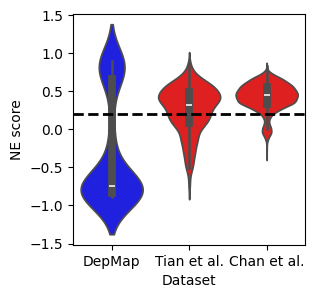

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming lung_cells_score, tang_ne_score, and chan_ne_score are already defined

# Create a DataFrame combining the scores and labeling the sources
combined_scores = pd.DataFrame({
    'NE_score': pd.concat([lung_cells_score, tang_ne_score, chan_ne_score]),
    'Source': ['DepMap'] * len(lung_cells_score) + 
              ['Tian et al.'] * len(tang_ne_score) + 
              ['Chan et al.'] * len(chan_ne_score)
})

# Create the violin plot
plt.figure(figsize=(3, 3))
sns.violinplot(x="Source", y="NE_score", data=combined_scores, palette=["blue", "red", "red"], inner=")

# Optional: Add jittered points
# sns.stripplot(x="Source", y="NE_score", data=combined_scores, 
#               color="black", size=1, jitter=True, alpha=0.4)

# Add a horizontal line at y=0.2
plt.axhline(y=0.2, color='black', linestyle='--', linewidth=2)

# Add title and labels
plt.xlabel("Dataset")
plt.ylabel("NE score")

# Save the figure
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/tumor_nescore_violin.png", dpi=600, bbox_inches='tight')


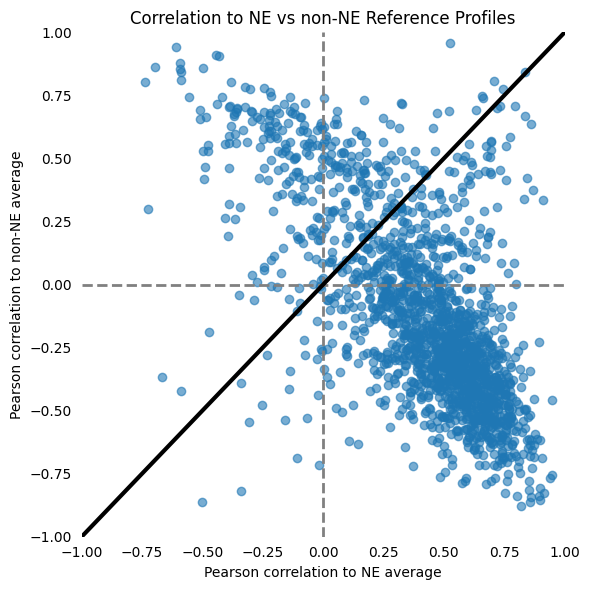

In [21]:
x=tang_pearson_correlation_to_ne
y=tang_pearson_correlation_to_nonne

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.6)

# Set axis limits
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Axis labels and title
plt.xlabel('Pearson correlation to NE average')
plt.ylabel('Pearson correlation to non-NE average')
plt.title('Correlation to NE vs non-NE Reference Profiles')

# Add x=0 and y=0 lines
plt.axhline(0, color='gray', linestyle='--', linewidth=2)
plt.axvline(0, color='gray', linestyle='--', linewidth=2)

# Add diagonal line
plt.plot([-1, 1], [-1, 1], linewidth=3, color='Black')

# Remove outer spines
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Optional: remove ticks
plt.tick_params(left=False, bottom=False)

plt.grid(False)
plt.tight_layout()
plt.show()

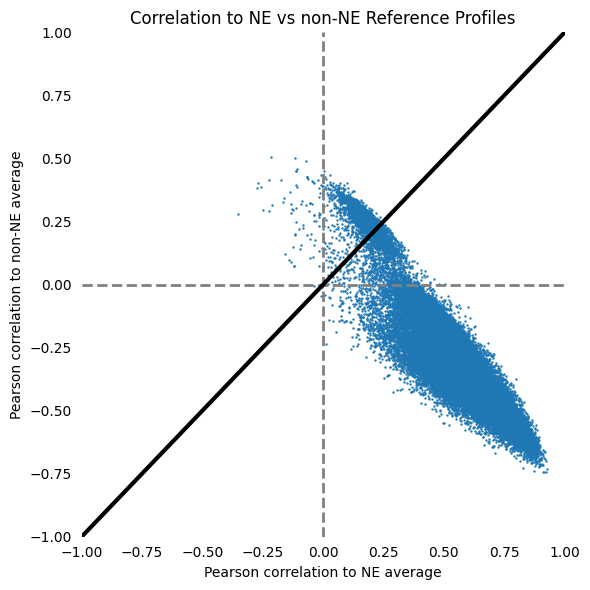

In [30]:
x=chan_pearson_correlation_to_ne
y=chan_pearson_correlation_to_nonne

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=1, s=0.5)

# Set axis limits
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Axis labels and title
plt.xlabel('Pearson correlation to NE average')
plt.ylabel('Pearson correlation to non-NE average')
plt.title('Correlation to NE vs non-NE Reference Profiles')

# Add x=0 and y=0 lines
plt.axhline(0, color='gray', linestyle='--', linewidth=2)
plt.axvline(0, color='gray', linestyle='--', linewidth=2)

# Add diagonal line
plt.plot([-1, 1], [-1, 1], linewidth=3, color='Black')

# Remove outer spines
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Optional: remove ticks
plt.tick_params(left=False, bottom=False)

plt.grid(False)
plt.tight_layout()
plt.show()

In [41]:
tumor_adata_normalized.obs['NE_status'] = tumor_adata_normalized.obs['NE_score'].apply(
    lambda x: 'NE' if x >= 0.2 else 'non-NE'
)

In [56]:
chan_adata.obs['NE_status'] = chan_adata.obs['NE_score'].apply(
    lambda x: 'NE' if x >= 0.2 else 'non-NE'
)

<Figure size 200x200 with 0 Axes>

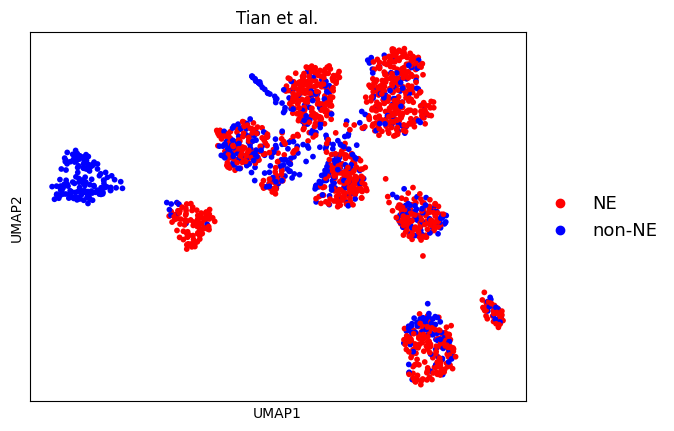

In [63]:
plt.figure(figsize=(2, 2))
sc.pl.umap(
    tumor_adata_normalized,
    color="NE_status",
    palette=["red", "blue"],title="Tian et al.", add_outline=False,show=False,legend_fontsize=13
)
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/tian_nestatus_umap.png", dpi=600,bbox_inches='tight')

<Figure size 200x200 with 0 Axes>

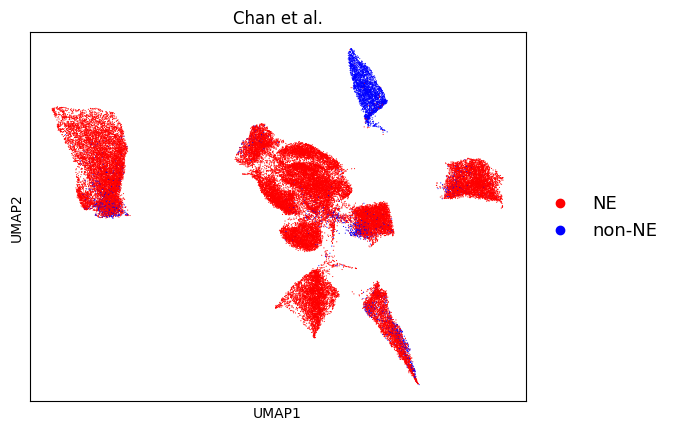

In [64]:
plt.figure(figsize=(2, 2))
sc.pl.umap(
    chan_adata,
    color="NE_status",
    palette=["red", "blue"],title="Chan et al.", add_outline=False,show=False,legend_fontsize=13
)
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/chan_nestatus_umap.png", dpi=600,bbox_inches='tight')

In [65]:
tumor_adata_normalized.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tumor_adata_normalized_nescore.h5ad")
chan_adata.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_nescore.h5ad")
lung_cz_healthy_epithelial.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/normal_lung/lung_cz_healthy_epithelial_nescore.h5ad")